In [73]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d2fd3f4a-5588-2bb7-a276-fad99adb7dc4)
GPU 1: Tesla T4 (UUID: GPU-321e8126-ca8a-d773-dc1d-efb623c3565e)


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

**Load the Data:**

In [75]:
bitcoin_prices_data = pd.read_csv('/kaggle/input/bitcoin-complete-data/BTC-USD (1).csv', parse_dates = ['Date'], index_col = ['Date'])
bitcoin_prices_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


**Check for null values in the data:**

In [76]:
bitcoin_prices_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

**Select the column which is required for the prediction:**

In [77]:
bitcoin_prices = pd.DataFrame(bitcoin_prices_data['Adj Close']).rename(columns = {'Adj Close': 'Prices'})
bitcoin_prices.head()

,Prices
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


**Plot the historical data onto a graph:**

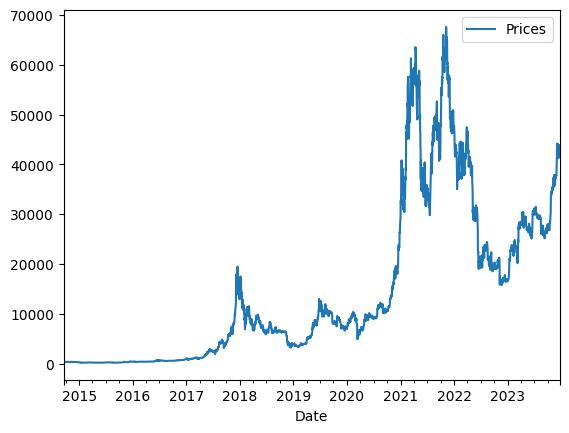

In [78]:
bitcoin_prices.plot();

**Ckeck for splitting:**

In [79]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Prices'].to_numpy()
split_size = int(0.8 * len(timesteps))
timesteps_train, prices_train = timesteps[:split_size], prices[:split_size]
timesteps_test, prices_test = timesteps[split_size:], prices[split_size:]
len(timesteps_train), len(prices_train), len(timesteps_test), len(prices_test)

(2707, 2707, 677, 677)

**Create a function for plotting the values:**

In [80]:
def plot_time_series(timesteps, values, start, end = None, format = '-', label = None):
    plt.plot(timesteps[start:end], values[start:end], format, label = label)
    plt.xlabel('Year')
    plt.ylabel('BTC Price')
    if label:
        plt.legend();
    plt.grid(True)

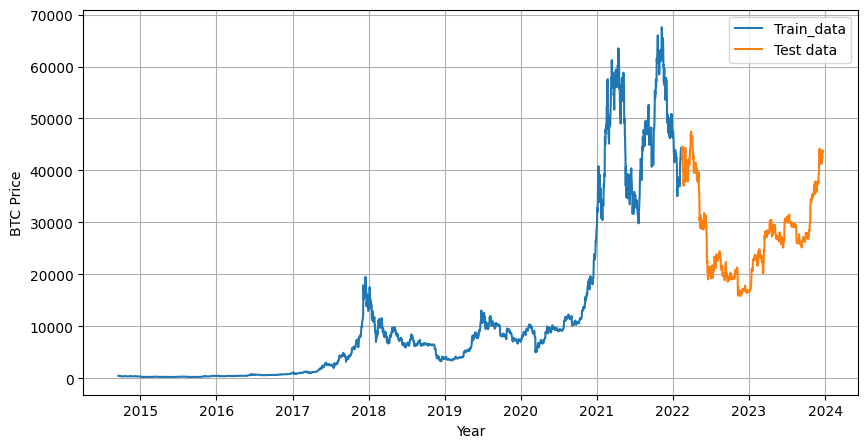

In [121]:
plt.figure(figsize = (10, 5))
plot_time_series(timesteps_train, prices_train, start = 0, label = 'Train_data')
plot_time_series(timesteps_test, prices_test, start = 0, label = 'Test data')

**Do some required data manipulation for Data Preparation:**

In [82]:
HORIZON = 1
WINDOW_SIZE = 7
for i in range(WINDOW_SIZE):
    bitcoin_prices[f'Prices+{i+1}'] = bitcoin_prices['Prices'].shift(periods = i + 1)
bitcoin_prices.head(10)

,Prices,Prices+1,Prices+2,Prices+3,Prices+4,Prices+5,Prices+6,Prices+7
Date,,,,,,,,
2014-09-17,457.334015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


In [83]:
X_all  = bitcoin_prices.dropna().drop('Prices', axis = 1).to_numpy()
y_all = bitcoin_prices.dropna()['Prices'].to_numpy()
len(X_all), len(y_all)

(3377, 3377)

**Prepare the dataset:**

In [84]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [85]:
tf.random.set_seed(42)
future_predictor_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(HORIZON)
])
future_predictor_model.compile(loss = tf.keras.losses.mae, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', 'mse'])
future_predictor_model.fit(dataset_all,
                       epochs = 1000,
                       callbacks =[tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 50, restore_best_weights = True),
                                  tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss', patience = 100, verbose = 1)],
                      verbose = 0)

In [86]:
def make_future_forecast(values, model, into_future, window_size = WINDOW_SIZE) -> list:
    future_forecast = []
    last_window = values[-window_size:]
    for _ in range(into_future):
        future_pred = model.predict(tf.expand_dims(last_window, axis = 0))
        print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
        future_forecast.append(tf.squeeze(future_pred).numpy())
        last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
    return future_forecast

In [102]:
future_forecasts = make_future_forecast(y_all, model = future_predictor_model, into_future = 14)

1/1 [==============================] - 0s 21ms/step
Predicting on: 
 [42240.117188 41364.664063 42623.539063 42270.527344 43652.25
 43869.152344 43663.847656] -> Prediction: 42742.52734375

1/1 [==============================] - 0s 19ms/step
Predicting on: 
 [41364.664063   42623.539063   42270.527344   43652.25
 43869.152344   43663.847656   42742.52734375] -> Prediction: 42532.65625

1/1 [==============================] - 0s 18ms/step
Predicting on: 
 [42623.539063   42270.527344   43652.25       43869.152344
 43663.847656   42742.52734375 42532.65625   ] -> Prediction: 43005.21484375

1/1 [==============================] - 0s 18ms/step
Predicting on: 
 [42270.527344   43652.25       43869.152344   43663.847656
 42742.52734375 42532.65625    43005.21484375] -> Prediction: 43061.90234375

1/1 [==============================] - 0s 19ms/step
Predicting on: 
 [43652.25       43869.152344   43663.847656   42742.52734375
 42532.65625    43005.21484375 43061.90234375] -> Prediction: 43469.2

In [103]:
future_forecasts

[42742.527,
 42532.656,
 43005.215,
 43061.902,
 43469.246,
 43396.72,
 43186.816,
 43033.01,
 43012.727,
 43201.785,
 43257.863,
 43337.348,
 43287.754,
 43210.344]

In [104]:
def get_future_dates(start_date, into_future, offset = 1):
    start_date = start_date + np.timedelta64(offset, 'D')
    end_date = start_date + np.timedelta64(into_future, 'D')
    return np.arange(start_date, end_date, dtype = 'datetime64[D]')

In [105]:
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2023-12-22 00:00:00')

In [106]:
next_time_steps = get_future_dates(start_date = last_timestep, into_future = 14)
next_time_steps

array(['2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26',
       '2023-12-27', '2023-12-28', '2023-12-29', '2023-12-30',
       '2023-12-31', '2024-01-01', '2024-01-02', '2024-01-03',
       '2024-01-04', '2024-01-05'], dtype='datetime64[D]')

In [107]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecasts, 0, prices[-1])
next_time_steps, future_forecast

(array(['2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
        '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
        '2023-12-30', '2023-12-31', '2024-01-01', '2024-01-02',
        '2024-01-03', '2024-01-04', '2024-01-05'], dtype='datetime64[D]'),
 array([43663.848, 42742.527, 42532.656, 43005.215, 43061.902, 43469.246,
        43396.72 , 43186.816, 43033.01 , 43012.727, 43201.785, 43257.863,
        43337.348, 43287.754, 43210.344], dtype=float32))

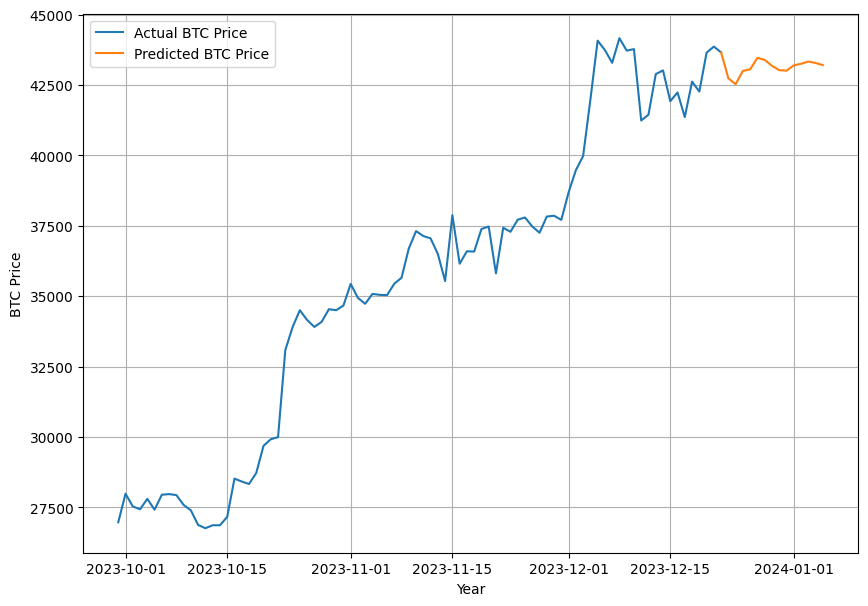

In [109]:
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, prices, start=3300, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, start = 0,format="-", label="Predicted BTC Price")

**Lets build a more accurate model without using prefetching**

In [112]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(HORIZON)
])
model_2.compile(loss = tf.keras.losses.mae, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', 'mse'])
model_2.fit(X_all, y_all, epochs = 1000, verbose = 0)

In [114]:
future_forecasts_2 = make_future_forecast(y_all, model_2, into_future = 14)
future_forecasts_2

1/1 [==============================] - 0s 19ms/step
Predicting on: 
 [42240.117188 41364.664063 42623.539063 42270.527344 43652.25
 43869.152344 43663.847656] -> Prediction: 42499.58984375

1/1 [==============================] - 0s 18ms/step
Predicting on: 
 [41364.664063   42623.539063   42270.527344   43652.25
 43869.152344   43663.847656   42499.58984375] -> Prediction: 41722.16015625

1/1 [==============================] - 0s 18ms/step
Predicting on: 
 [42623.539063   42270.527344   43652.25       43869.152344
 43663.847656   42499.58984375 41722.16015625] -> Prediction: 42879.30078125

1/1 [==============================] - 0s 18ms/step
Predicting on: 
 [42270.527344   43652.25       43869.152344   43663.847656
 42499.58984375 41722.16015625 42879.30078125] -> Prediction: 42611.50390625

1/1 [==============================] - 0s 18ms/step
Predicting on: 
 [43652.25       43869.152344   43663.847656   42499.58984375
 41722.16015625 42879.30078125 42611.50390625] -> Prediction: 4396

[42499.59,
 41722.16,
 42879.3,
 42611.504,
 43967.918,
 44122.594,
 43851.246,
 42764.863,
 42072.977,
 43142.758,
 42955.793,
 44278.01,
 44373.668,
 44049.363]

In [115]:
next_time_steps_2 = get_future_dates(start_date = last_timestep, into_future = 14)
next_time_steps_2

array(['2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26',
       '2023-12-27', '2023-12-28', '2023-12-29', '2023-12-30',
       '2023-12-31', '2024-01-01', '2024-01-02', '2024-01-03',
       '2024-01-04', '2024-01-05'], dtype='datetime64[D]')

In [118]:
next_time_steps_2 = np.insert(next_time_steps_2, 0, last_timestep)
future_forecast_2 = np.insert(future_forecasts_2, 0, prices[-1])
next_time_steps_2, future_forecast_2

(array(['2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
        '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
        '2023-12-30', '2023-12-31', '2024-01-01', '2024-01-02',
        '2024-01-03', '2024-01-04', '2024-01-05'], dtype='datetime64[D]'),
 array([43663.848, 42499.59 , 41722.16 , 42879.3  , 42611.504, 43967.918,
        44122.594, 43851.246, 42764.863, 42072.977, 43142.758, 42955.793,
        44278.01 , 44373.668, 44049.363], dtype=float32))

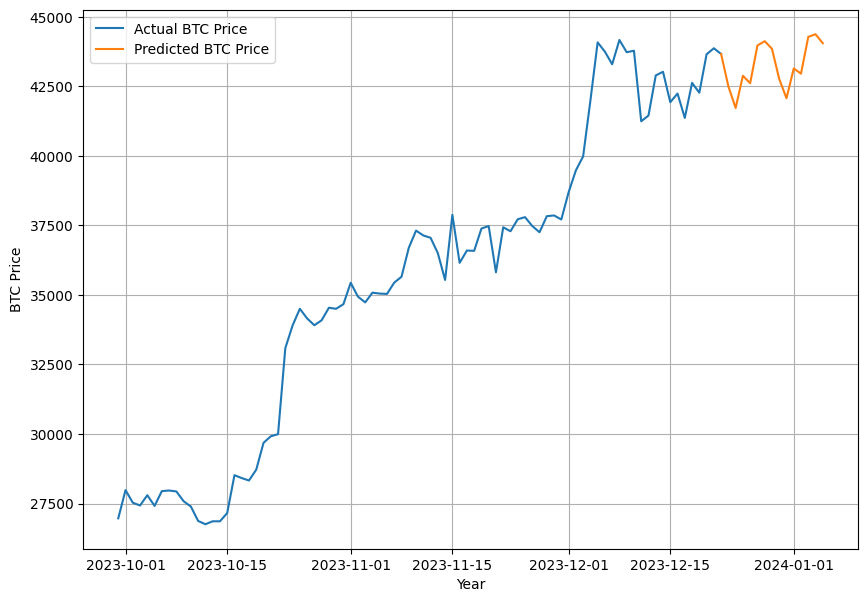

In [119]:
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, prices, start=3300, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps_2, future_forecast_2, start = 0,format="-", label="Predicted BTC Price")

**The graph above shows Bitcoin Closing prices upto 1 Jan 2024:**